In [1]:
# import zipfile
# import os

# zip_path = "chest_xray.zip"      # update this
# extract_to = "chest_xray_grad"   # update this

# # Create directory if it doesn't exist
# os.makedirs(extract_to, exist_ok=True)

# with zipfile.ZipFile(zip_path, 'r') as zip_ref:
#     zip_ref.extractall(extract_to)

# print("Extraction complete!")


In [12]:
# import shutil
# import os

# folder_path = "chest_xray_grad"   # <-- replace with your folder path

# if os.path.exists(folder_path):
#     shutil.rmtree(folder_path)
#     print("Folder deleted successfully!")
# else:
#     print("Folder does not exist.")


In [13]:
# !pip install -q grad-cam

In [14]:
from PIL import Image
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image
from sklearn.metrics import confusion_matrix, classification_report
from tqdm import tqdm
from typing import Tuple
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import torch.optim as optim
import torch.nn as nn
import torch
import numpy as np
import random
import warnings
import shutil
import os

warnings.filterwarnings('ignore')
matplotlib.style.use('ggplot')

In [15]:
# For reproducibility
seed = 27
random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

In [16]:
dataset_path = 'chest_xray/chest_xray/'

train_path = f'{dataset_path}/train/'
val_path = f'{dataset_path}/val/'
test_path = f'{dataset_path}/test/'

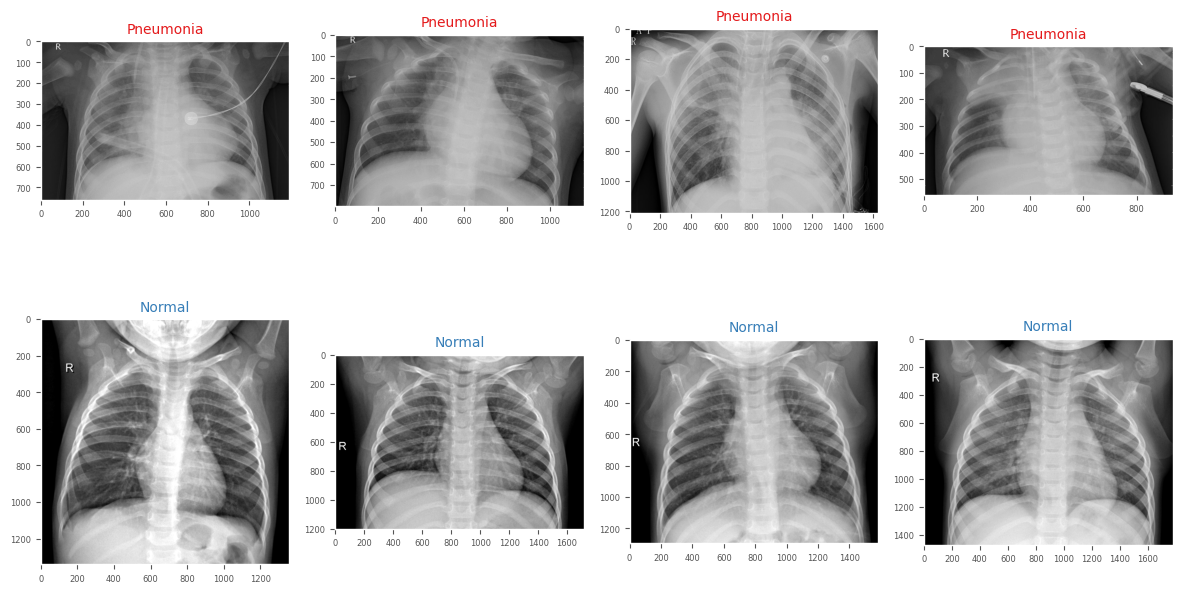

In [17]:
random_pneumonia_samples = random.sample(os.listdir(f'{train_path}/PNEUMONIA'), 4)
random_non_pneumonia_samples = random.sample(os.listdir(f'{train_path}/NORMAL'), 4)

plt.rcParams['axes.grid'] = False
colors = sns.color_palette('Set1', 2)
fig, ax = plt.subplots(2, 4, figsize=(12, 7))
ax = ax.flatten()

for i in range(4):
    filename = random_pneumonia_samples[i]
    image = Image.open(f'{train_path}/PNEUMONIA/{filename}')
    ax[i].imshow(image, cmap='gray')
    ax[i].set_title('Pneumonia', color=colors[0], fontsize=10)
    ax[i].tick_params(axis='both', which='major', labelsize=6)

for i in range(4, 8):
    filename = random_non_pneumonia_samples[i-5]
    image = Image.open(f'{train_path}/NORMAL/{filename}')
    ax[i].imshow(image, cmap='gray')
    ax[i].set_title('Normal', color=colors[1], fontsize=10)
    ax[i].tick_params(axis='both', which='major', labelsize=6)


plt.tight_layout()
plt.show()

In [18]:
def plot_label_distribution(train_path: str, val_path: str, test_path: str) -> None:
    plt.rcParams['axes.grid'] = True
    train_counts = [len(os.listdir(f'{train_path}/{cls}')) for cls in ['NORMAL', 'PNEUMONIA']]
    val_counts = [len(os.listdir(f'{val_path}/{cls}')) for cls in ['NORMAL', 'PNEUMONIA']]
    test_counts = [len(os.listdir(f'{test_path}/{cls}')) for cls in ['NORMAL', 'PNEUMONIA']]
    total_counts = [sum(x) for x in zip(train_counts, val_counts, test_counts)]

    total_train = sum(train_counts)
    total_val = sum(val_counts)
    total_test = sum(test_counts)
    total_images = sum(total_counts)

    fig, ax = plt.subplots(1, 4, figsize=(14, 5))
    bars0 = ax[0].bar(['Normal', 'Pneumonia'], train_counts, color=colors)
    ax[0].set_title('Train')
    ax[0].set_ylabel('Number of images')
    bars1 = ax[1].bar(['Normal', 'Pneumonia'], val_counts, color=colors)
    ax[1].set_title('Validation')
    bars2 = ax[2].bar(['Normal', 'Pneumonia'], test_counts, color=colors)
    ax[2].set_title('Test')
    bars3 = ax[3].bar(['Normal', 'Pneumonia'], total_counts, color=colors)
    ax[3].set_title('Total')

    def add_labels(bars, ax, total):
        for bar in bars:
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width() / 2, height,
                    f'{height} ({height / total:.1%})',
                    ha='center', va='bottom')

    add_labels(bars0, ax[0], total_train)
    add_labels(bars1, ax[1], total_val)
    add_labels(bars2, ax[2], total_test)
    add_labels(bars3, ax[3], total_images)

    plt.tight_layout()
    plt.show()

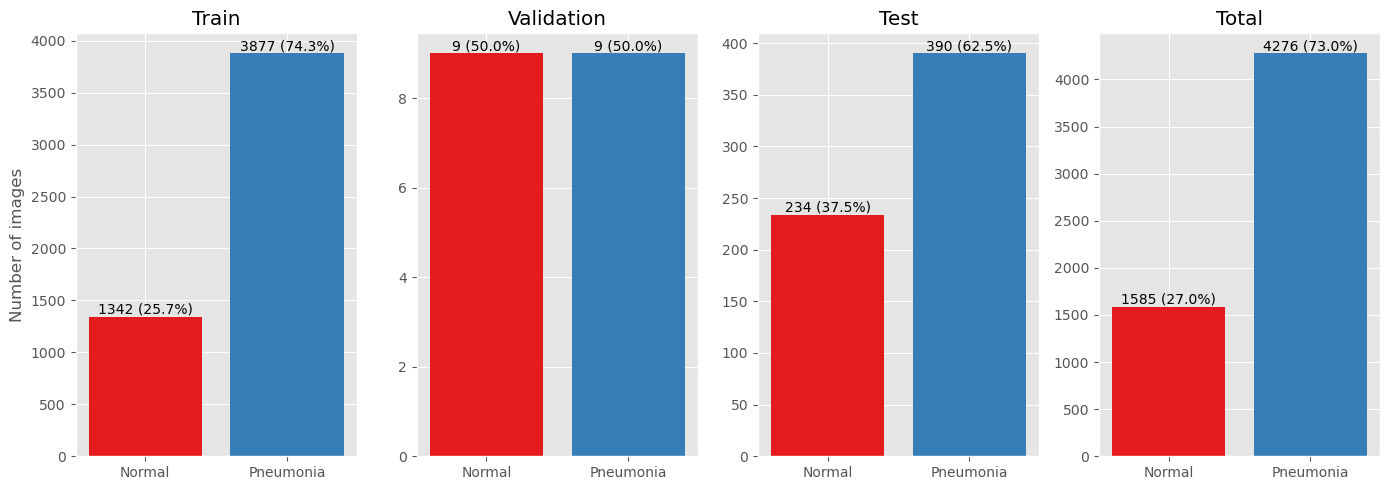

In [19]:
plot_label_distribution(train_path, val_path, test_path)

In [20]:
# new_dataset_path = 'chest_xray_grad/'
# new_train_path = f'{new_dataset_path}train/'
# new_val_path = f'{new_dataset_path}val/'
# new_test_path = f'{new_dataset_path}test/'

# if not os.path.exists(new_dataset_path):
#     for split in ['train', 'val', 'test']:
#         for cls in ['NORMAL', 'PNEUMONIA']:
#             os.makedirs(f'{new_dataset_path}/{split}/{cls}', exist_ok=True)
            
#     for cls in ['NORMAL', 'PNEUMONIA']:
#         all_files = []
#         for split in ['train', 'val', 'test']:
#             source_folder = f'{dataset_path}/{split}/{cls}'
#             files = os.listdir(source_folder)
#             all_files.extend([(file, source_folder) for file in files])
        
#         random.shuffle(all_files)
        
#         train_files = all_files[:int(len(all_files)*0.8)]
#         val_files = all_files[int(len(all_files)*0.8):int(len(all_files)*0.9)]
#         test_files = all_files[int(len(all_files)*0.9):]
        
#         for file, source_folder in train_files:
#             dest = f'{new_dataset_path}/train/{cls}/{file}'
#             shutil.copy(f'{source_folder}/{file}', dest)
        
#         for file, source_folder in val_files:
#             dest = f'{new_dataset_path}/val/{cls}/{file}'
#             shutil.copy(f'{source_folder}/{file}', dest)
        
#         for file, source_folder in test_files:
#             dest = f'{new_dataset_path}/test/{cls}/{file}'
#             shutil.copy(f'{source_folder}/{file}', dest) 
new_dataset_path = "chest_xray_grad"
splits = ["train", "val", "test"]
classes = ["NORMAL", "PNEUMONIA"]

# Create new folders
for split in splits:
    for cls in classes:
        os.makedirs(os.path.join(new_dataset_path, split, cls), exist_ok=True)

for cls in classes:
    all_files = []

    # Collect ALL images from all original splits
    for split in splits:
        source_folder = os.path.join(dataset_path, split, cls)

        # Only include actual files (NOT directories like .ipynb_checkpoints)
        files = [
            f for f in os.listdir(source_folder)
            if os.path.isfile(os.path.join(source_folder, f))
        ]

        for file in files:
            all_files.append((file, source_folder))

    random.shuffle(all_files)

    n = len(all_files)
    train_files = all_files[:int(n * 0.8)]
    val_files   = all_files[int(n * 0.8):int(n * 0.9)]
    test_files  = all_files[int(n * 0.9):]

    # Copy files safely
    def copy_files(file_list, split):
        for file, src in file_list:
            src_path = os.path.join(src, file)
            dest_path = os.path.join(new_dataset_path, split, cls, file)
            shutil.copy(src_path, dest_path)

    copy_files(train_files, "train")
    copy_files(val_files, "val")
    copy_files(test_files, "test")

    print(f"{cls}: train={len(train_files)}, val={len(val_files)}, test={len(test_files)})")


NORMAL: train=1268, val=158, test=159)
PNEUMONIA: train=3420, val=427, test=428)


In [22]:
new_train_path = os.path.join(new_dataset_path, "train")
new_val_path   = os.path.join(new_dataset_path, "val")
new_test_path  = os.path.join(new_dataset_path, "test")

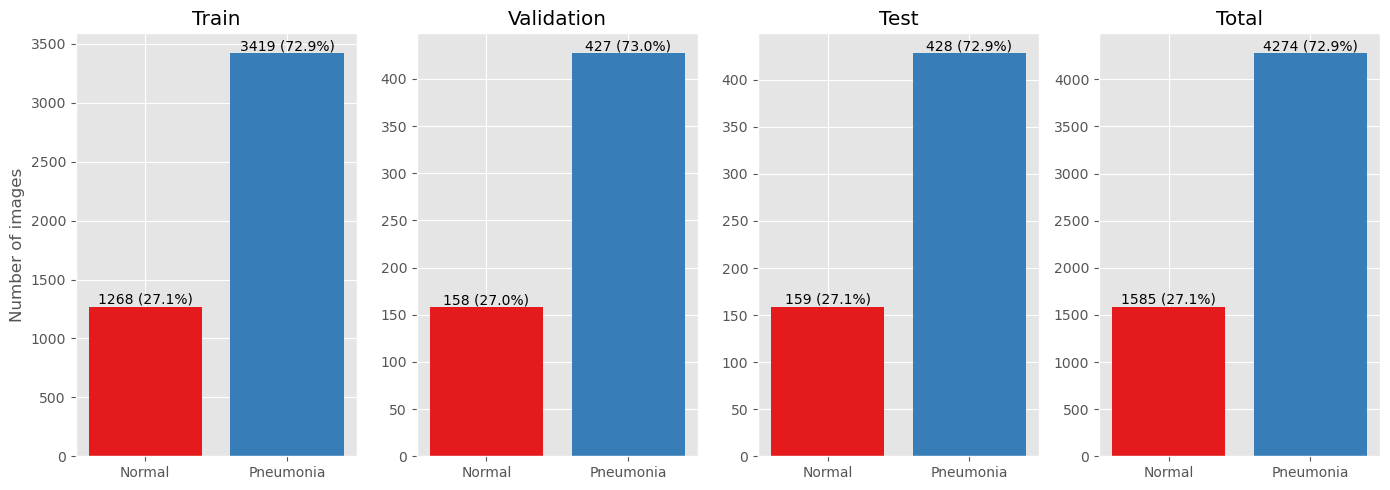

In [23]:
plot_label_distribution(new_train_path, new_val_path, new_test_path)

In [24]:
IMAGE_SIZE = (64, 64)
BATCH_SIZE = 16
NUM_WORKERS = 4
DATA_TYPES = ['train', 'val', 'test']

data_transforms = {
    'train': transforms.Compose([
        transforms.RandomVerticalFlip(p=0.2),
        transforms.RandomHorizontalFlip(p=0.2),
        transforms.Resize(IMAGE_SIZE),
        transforms.ToTensor(),
        transforms.Normalize([0.4822, 0.4822, 0.4822], [0.2362, 0.2362, 0.2362])
    ]),
    'val': transforms.Compose([
        transforms.Resize(IMAGE_SIZE),
        transforms.ToTensor(),
        transforms.Normalize([0.4822, 0.4822, 0.4822], [0.2362, 0.2362, 0.2362])
    ]),
    'test': transforms.Compose([
        transforms.Resize(IMAGE_SIZE),
        transforms.ToTensor(),
        transforms.Normalize([0.4822, 0.4822, 0.4822], [0.2362, 0.2362, 0.2362])
    ]),
}

image_datasets = {x: datasets.ImageFolder(os.path.join(new_dataset_path, x), data_transforms[x]) for x in DATA_TYPES}
dataloaders = {x: DataLoader(image_datasets[x], batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS) for x in DATA_TYPES}
dataset_sizes = {x: len(image_datasets[x]) for x in DATA_TYPES}
class_names = image_datasets['train'].classes

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [25]:
# # import os

# # for split in ['train', 'val', 'test']:
# #     print("----", split, "----")
# #     path = os.path.join(new_dataset_path, split)
# #     print("Exists:", os.path.exists(path))
# #     print("Subfolders:", os.listdir(path))
# import os

# for split in ['train', 'val', 'test']:
#     pneu_path = os.path.join(new_dataset_path, split, "PNEUMONIA")
#     files = os.listdir(pneu_path)
#     print(f"{split} PNEUMONIA count:", len(files))
#     print("First few:", files[:5])


In [26]:
# import os

# print(os.listdir('/home/vsinha'))

In [28]:
class Trainer:
    def __init__(
        self,
        device: str,
        model: torch.nn.Module,
        criterion: torch.nn.Module,
        optimizer: torch.optim.Optimizer,
        scheduler: torch.optim.lr_scheduler,
        train_dataloader: DataLoader,
        val_dataloader: DataLoader,
        test_dataloader: DataLoader,
        checkpoint_path: str,
        pneumonia_samples: str
    ):
        self.device = device
        self.model = model
        self.criterion = criterion
        self.optimizer = optimizer
        self.scheduler = scheduler
        self.train_dataloader = train_dataloader
        self.val_dataloader = val_dataloader
        self.test_dataloader = test_dataloader
        self.checkpoint_path = checkpoint_path
        self.best_accuracy = 0.0
        self.best_model_path = None
        self.pneumonia_samples = pneumonia_samples
        
    def save_cam_samples(self, model: models.resnet.ResNet, epoch_nr: int) -> None:
        targets = [1, 1, 1, 1, 1]
        
        target_layer = [model.Mixed_7c]
        cam = GradCAM(model=model, target_layers=target_layer)

        plt.rcParams['axes.grid'] = False

        for i, (image_path, target) in enumerate(zip(self.pneumonia_samples, targets)):
            image = Image.open(image_path).convert('RGB')
            image_tensor = transforms.ToTensor()(image).unsqueeze(0)
            
            image = transforms.ToTensor()(image)
            image = image.numpy().transpose((1, 2, 0))
            image = np.clip(image, 0, 1)
            
            targets = [ClassifierOutputTarget(target)]
            grayscale_cam = cam(input_tensor=image_tensor, targets=targets)
            grayscale_cam = grayscale_cam[0, :]

            visualization = show_cam_on_image(np.array(image_tensor[0].permute(1, 2, 0)), grayscale_cam, use_rgb=True)

            filename = image_path.split('/')[-1].split('.')[0]
            filetype = image_path.split('/')[-1].split('.')[1]
            plt.imshow(visualization)
            plt.axis('off') 
            plt.savefig(f'samples/{filename}-cam-epoch-{epoch_nr}.{filetype}', bbox_inches='tight', pad_inches=0)
            plt.close()

    def train(self, current_epoch_nr: int) -> Tuple[float, float]:
        self.model.train()

        num_batches = len(self.train_dataloader)

        running_loss = 0.0
        n_corrects = 0
        total = 0
        
        # if current_epoch_nr == 1:
        #     self.save_cam_samples(self.model, 0)

        loop = tqdm(self.train_dataloader, total=num_batches)
        for batch in loop:
            x, y = batch
            x, y = x.to(self.device), y.to(self.device)

            self.optimizer.zero_grad()

            y_hat = self.model(x)            
            _, preds = torch.max(y_hat, 1)
            loss = self.criterion(y_hat, y)

            loss.backward()
            self.optimizer.step()

            running_loss += loss.item() * x.size(0)
            n_corrects += torch.sum(preds == y.data).data.item()
            total += y.size(0)

            loop.set_description(f'Epoch {current_epoch_nr}')
            loop.set_postfix(train_acc=round(n_corrects / total, 5),
                             train_loss=round(running_loss / total, 5))
            
        self.scheduler.step()

        train_accuracy = n_corrects / total
        train_loss = running_loss / num_batches

        return train_accuracy, train_loss

    def evaluate(self, current_epoch_nr: int) -> Tuple[float, float]:
        self.model.eval()

        num_batches = len(self.val_dataloader)

        running_loss = 0.0
        n_corrects = 0
        total = 0

        with torch.no_grad():
            loop = tqdm(self.val_dataloader, total=num_batches)
            for batch in loop:
                x, y = batch
                x, y = x.to(self.device), y.to(self.device)

                self.optimizer.zero_grad()

                y_hat = self.model(x)
                _, preds = torch.max(y_hat, 1)
                loss = self.criterion(y_hat, y)

                running_loss += loss.item() * x.size(0)
                n_corrects += torch.sum(preds == y.data).data.item()
                total += y.size(0)
                

                loop.set_description(f'Epoch {current_epoch_nr}')
                loop.set_postfix(val_acc=round(n_corrects / total, 5),
                                 val_loss=round(running_loss / total, 5))

        val_accuracy = n_corrects / total
        val_loss = running_loss / num_batches

        # self.save_cam_samples(self.model, current_epoch_nr)
        if val_accuracy > self.best_accuracy:
            self.best_accuracy = val_accuracy
            checkpoint_name = f'epoch_{current_epoch_nr}_acc_{round(val_accuracy, 2)}.pth'
            torch.save(
                self.model.state_dict(),
                os.path.join(self.checkpoint_path, checkpoint_name)
            )
            self.best_model_path = os.path.join(self.checkpoint_path, checkpoint_name)

        return val_accuracy, val_loss

    def test(self) -> Tuple[float, float, list, list, models.resnet.ResNet]:
        self.model.eval()

        num_batches = len(self.test_dataloader)

        running_loss = 0.0
        n_corrects = 0
        total = 0
        
        targets = []
        predictions = []

        with torch.no_grad():
            loop = tqdm(self.test_dataloader, total=num_batches)
            for batch in loop:
                x, y = batch
                x, y = x.to(self.device), y.to(self.device)

                y_hat = self.model(x)                
                _, preds = torch.max(y_hat, 1)
                loss = self.criterion(y_hat, y)

                running_loss += loss.item() * x.size(0)
                n_corrects += torch.sum(preds == y.data).data.item()
                total += y.size(0)
                
                targets.extend(y.cpu().numpy())
                predictions.extend(preds.cpu().numpy())

                loop.set_description('Testing')
                loop.set_postfix(test_acc=round(n_corrects / total, 5),
                                 test_loss=round(running_loss / total, 5))

        test_accuracy = n_corrects / total
        test_loss = running_loss / num_batches
        
        print('\nTest Accuracy: ', test_accuracy)
        print('Test Loss: ', test_loss)

        self.model.load_state_dict(torch.load(self.best_model_path))
        
        return test_accuracy, test_loss, targets, predictions, self.model
    
# I will use these samples to visualize with Grad-CAM
new_test_path = "chest_xray_grad/test/"
pneumonia_samples = [
    new_test_path + 'PNEUMONIA/person1_virus_13.jpeg',
    # new_test_path + 'PNEUMONIA/person1016_virus_1704.jpeg',
    # new_test_path + 'PNEUMONIA/person1308_bacteria_3285.jpeg',
    # new_test_path + 'PNEUMONIA/person1472_bacteria_3833.jpeg',
    # new_test_path + 'PNEUMONIA/person305_bacteria_1436.jpeg'
]
os.makedirs('samples', exist_ok=True)
for sample in pneumonia_samples:
    img = Image.open(sample)
    img.save('samples/' + sample.split('/')[-1])

In [29]:
# print(new_test_path)

In [33]:
import torch
import torch.nn as nn
from torchvision import models

class VGG16Custom(nn.Module):
    def __init__(self, num_classes=2):
        super(VGG16Custom, self).__init__()

        # Load pretrained VGG16 without classifier
        self.base = models.vgg16(weights=models.VGG16_Weights.IMAGENET1K_V1)

        # Remove classifier, keep only convolutional layers
        self.features = self.base.features

        # Use adaptive max pooling (same as pooling="max" in TF)
        self.pool = nn.AdaptiveMaxPool2d((1, 1))

        # New classifier head (same architecture as your TF version)
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.BatchNorm1d(256),
            nn.Dropout(0.4),

            nn.Linear(256, 128),
            nn.ReLU(),
            nn.BatchNorm1d(128),
            nn.Dropout(0.3),

            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.pool(x)
        x = self.classifier(x)
        return x


In [34]:
# model = models.inception_v3()
# n_features = model.fc.in_features
# model.fc = nn.Linear(n_features, len(class_names))
# model.aux_logits = False
# model = model.to(device)
model = VGG16Custom(num_classes=len(class_names)).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.0005)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /home/vsinha/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:07<00:00, 70.9MB/s] 


OutOfMemoryError: CUDA out of memory. Tried to allocate 20.00 MiB. GPU 0 has a total capacity of 10.91 GiB of which 4.06 MiB is free. Process 792448 has 10.45 GiB memory in use. Process 814936 has 470.00 MiB memory in use. Of the allocated memory 295.17 MiB is allocated by PyTorch, and 10.83 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [32]:
max_epochs = 10

train_dataloader = dataloaders['train']
val_dataloader = dataloaders['val']
test_dataloader = dataloaders['test']

checkpoint_path = 'checkpoints'
try:
    os.mkdir(checkpoint_path)
except FileExistsError:
    pass


trainer = Trainer(
    device=device,
    model=model,
    criterion=criterion,
    optimizer=optimizer,
    scheduler=scheduler,
    train_dataloader=train_dataloader,
    val_dataloader=val_dataloader,
    test_dataloader=test_dataloader,
    checkpoint_path=checkpoint_path,
    pneumonia_samples=pneumonia_samples
)

histories = []
for epoch in range(1, max_epochs + 1):
    train_acc, train_loss = trainer.train(current_epoch_nr=epoch)
    val_acc, val_loss = trainer.evaluate(current_epoch_nr=epoch)
    
    histories.append({
        'epoch': epoch,
        'train_acc': train_acc,
        'train_loss': train_loss,
        'val_acc': val_acc,
        'val_loss': val_loss
    })

test_acc, test_loss, targets, predictions, best_model = trainer.test()
trainer.save_cam_samples(best_model, "final")

OutOfMemoryError: CUDA out of memory. Tried to allocate 24.00 MiB. GPU 0 has a total capacity of 10.91 GiB of which 4.06 MiB is free. Process 792448 has 10.45 GiB memory in use. Process 814936 has 470.00 MiB memory in use. Of the allocated memory 292.87 MiB is allocated by PyTorch, and 13.13 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [28]:
for split in ["train", "val", "test"]:
    for cls in ["NORMAL", "PNEUMONIA"]:
        folder = f"{dataset_path}/{split}/{cls}"
        print(split, cls, len(os.listdir(folder)))


train NORMAL 1342
train PNEUMONIA 3877
val NORMAL 9
val PNEUMONIA 9
test NORMAL 234
test PNEUMONIA 390
